## Project: Wildfire Severity Project  

### Module 3: *Class Balancing*

---
### Contents  
- 1. Data Preperation
- 2. Class Balancing
---
### Class Balancing:

**WARNING** this module is computation heavy
- Start with a **baseline model** for comparison.
- Test with multi-classification **tree-based models** (Random Forest, XGBoost) and KNN.
- Test and evaluate multiple class balancing strategies (No sampling, Oversampling, Undersampling
- Compare strategies analyzing average F1 score among all classes

---
### Inputs
- `X`,`pal_X`,`dixie_X`
- `y`

---
### Outputs  

`best_strategy` - dataframe recording best sampling strategy for each method

---
### User Created Dependencies

In [1]:
# Add the parent directory to the system path so "src" can be found
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

# user built utilities
from src.model_utils import gen_report
from src.model_utils import kfold

---
### Third Party Dependencies

In [2]:
# Core Python libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# Resampling tools
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# XGBoost
import xgboost as xgb

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Style
sns.set(style='whitegrid')
plt.rcParams["figure.dpi"] = 100

In [3]:
# Load processed feature and label data
X = pd.read_csv('../data/processed/X.csv')
pal_X = pd.read_csv('../data/processed/pal_X.csv')
dixie_X = pd.read_csv('../data/processed/dixie_X.csv')
y = pd.read_csv('../data/processed/y.csv').squeeze()

## 1. Prepare Data for Modeling - Scaling, Splitting, and Resampling

### 1.1 Data Overview

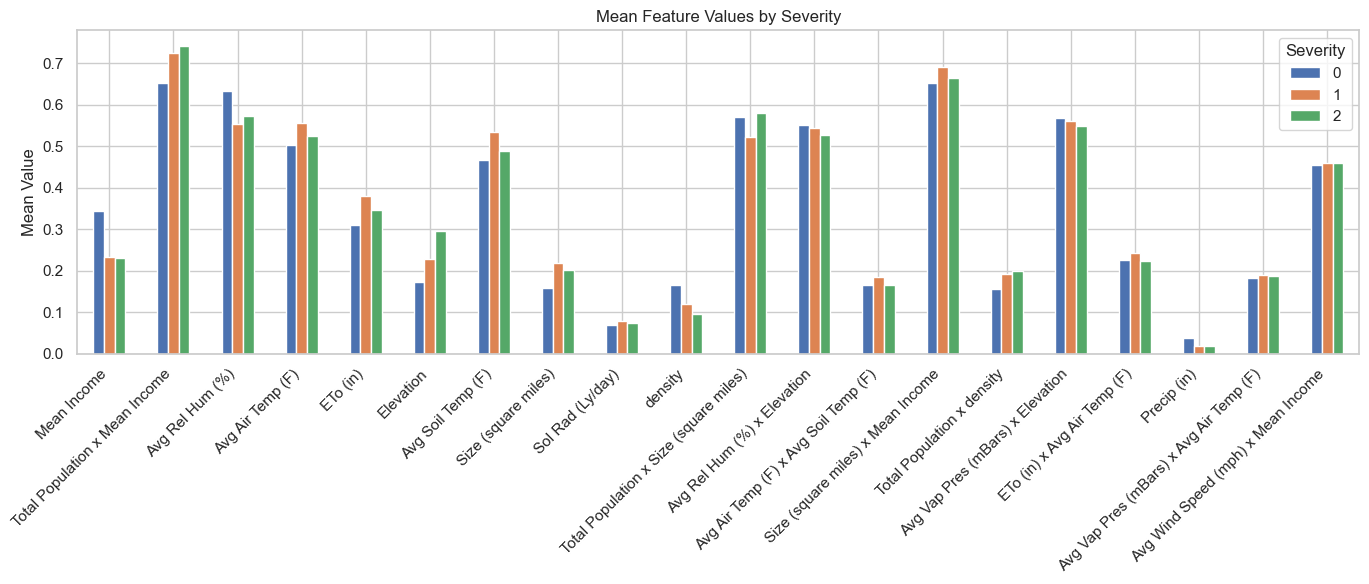

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming X is your feature DataFrame and y is your target Series
df = X.copy()
df['Severity'] = y

# Group by severity and take means
group_means = df.groupby('Severity').mean().T

# Plot
group_means.plot(kind='bar', figsize=(14, 6))
plt.title("Mean Feature Values by Severity")
plt.ylabel("Mean Value")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title='Severity')
plt.show()

### 1.2 Split Data

In [6]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [7]:
def manual_undersampling(X_train, y_train):
    
    # Sample 3,000 'Low' cases
    low_indices = y_train[y_train == 0].sample(n=3000, random_state=42).index

    # Get all 'Moderate' and 'High' indices
    other_indices = y_train[y_train != 0].index

    # Combine sampled 'Low' with all others
    final_indices = low_indices.union(other_indices)

    # Subset X and y
    X_train = X_train.loc[final_indices].reset_index(drop=True)
    y_train = y_train.loc[final_indices].reset_index(drop=True)
    
    return X_train, y_train

### 1.3 Class Balancing

To address the extreme inbalance in the dataset, multiple strategies are explored.
- **In Method Balancing** is used when applicable 
- **RandomUnderSampler** will remove random members of the majority class (Low severity) until they are balanced. This creates a much smaller dataset to model.
- **SMOTE (Synthetic Minority Over-sampling Technique)** will generate synthetic members of the minority classes. Introduces potential noise by synthetic sampling

## 2. Sample Balancing

### 2.1 Utility functions

A function to perform both in and out of sample testing with kfold crossvalidation and generate a report of metrics.

In [9]:
def class_balancing(X_train, y_train, X_test, y_test, model, sampling_strategy='No_balance'):
    
    if sampling_strategy == 'Undersampling':
        X_train, y_train = manual_undersampling(X_train, y_train)
   
    if sampling_strategy == 'Oversampling':
        smote = SMOTE()
        X_train, y_train = smote.fit_resample(X_train, y_train)
        
    print("running...")    
    reports = kfold(X_train, y_train, model)    
    Train_metrics = gen_report(reports)

    # Retrain on full training set
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    reports = [classification_report(y_test, y_pred, output_dict=True)]
    Test_metrics = gen_report(reports)

    # Add context columns
    for df in [Train_metrics, Test_metrics]:
        df['Phase'] = 'Train' if df is Train_metrics else 'Test'
        df['Model'] = model.__class__.__name__
        df['Balancing'] = sampling_strategy

    # Combine and reorder
    combined_metrics = pd.concat([Train_metrics, Test_metrics], axis=0)
    combined_metrics = combined_metrics.reset_index().rename(columns={'index': 'Class'})

    return combined_metrics

### 2.2 Define default machine learning models

In [10]:
default_rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
)

In [11]:
default_knn_model = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',   # closer neighbors count more
)


In [12]:
default_xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    use_label_encoder=False,
    eval_metric='logloss',
) 

 ###  2.3 Compare Sampling Methods

In [13]:
models = {
    'Random Forest': default_rf_model,
    'KNN': default_knn_model,
    'XGBoost': default_xgb_model
}

sampling_strategies = ['Undersampling','No_balance','Oversampling']

all_results = []

for strategy in sampling_strategies:
    for name, model in models.items():
        
        result = class_balancing(
            X_train, y_train, X_test, y_test,
            model,
            sampling_strategy=strategy
        )
        result['Model_Label'] = name
        all_results.append(result)

# Combine into one DataFrame
all_results_df = pd.concat(all_results, axis=0).reset_index(drop=True)

.
.
.
.
.
.
.
.
.


Format and display results

In [14]:
strategy_summary = (
    all_results_df[all_results_df['Phase'] == 'Test']
    .groupby(['Balancing','Model_Label'])['F1-Score']
    .mean()
    .reset_index()
    .sort_values(by='F1-Score', ascending=False)
)

strategy_summary_pivot = (
    strategy_summary
    .pivot(index='Model_Label', columns='Balancing', values='F1-Score')
    .sort_values(by='No_balance', ascending=False)  # or sort by any column you prefer
)

strategy_summary_pivot.style.highlight_max(axis=1, color='lightgreen')

Balancing,No_balance,Oversampling,Undersampling
Model_Label,,,
KNN,0.550675,0.526651,0.413644
Random Forest,0.476930,0.466348,0.441041
XGBoost,0.427232,0.490252,0.455300


## Best Strategies
**Random Forest** - In method balancing\
**KNN** - In method balancing\
**XGBoost** - Oversampling

In [15]:
# Find best balancing strategy per model
best_strategy = strategy_summary_pivot.idxmax(axis=1)

# Combine with model names into a new DataFrame
best_strategy_df = pd.DataFrame({
    'Model_Label': best_strategy.index,
    'Best_Strategy': best_strategy.values
})

best_strategy_df.to_csv('../data/processed/best_strategy.csv')